## Simulation code for the example treated in the paper: *Index-2 hybrid DAE: a case study with well-posedness and numerical analysis*



In [1]:
# MODULES NEEDED FOR THE SIMULATION

import siconos.numerics as sn
import scipy.linalg as linalg
import numpy as np
import siconos.kernel as sk
from numpy import eye, empty, float64, zeros, transpose, array
from siconos.kernel import FirstOrderLinearTIDS, FirstOrderType2R, FirstOrderLinearTIR, EqualityConditionNSL, RelayNSL,\
                           ComplementarityConditionNSL, NonSmoothDynamicalSystem, Interaction, \
                           EulerMoreauOSI, MoreauJeanOSI, LCP, TimeDiscretisation, TimeStepping 
import siconos.numerics as sn


### Definition of the simulated Non-Smooth DAE

Here we consider Non-smooth DAE put under the formulation of Linear Complementarity Systems with a singular matrix $M$. It follows, the variable $y$ is the aggregation of the differential variables $x$ and the algebraic variable $z$.

$$ 
\left\{
\begin{aligned}
    M\,\dot{y} =&~ A\,y  + R\,\lambda + b\\
    w =&~ C\,y + D\,\lambda + e \\
    0\leq&~ w \perp \lambda \geq 0
\end{aligned}
\right.
$$

In [2]:
class Problem:
    
    # Constructor of the Problem class: Store all the needed matrices.
    # Problem type are example specific and limited to
    # sliding-crossing, sliding-repulsive, non-null-A
    def __init__(self,A,R,b,C,D,e,M,init,T,typeProblem):
        
        self.type = typeProblem
        
        self.init = init
        self.T = T
        # note that t0 = 0 
        
        self.A  = A
        self.R  = R
        self.b  = b
        self.C  = C
        self.D  = D
        self.e  = e
        self.M  = M        

In [3]:
class ConvergenceTest:
    
    # Constructor of the simulation engine class: ConvergenceTest
    def __init__(self,problem,timeSteps):
        self.problem = problem
        self.timeSteps = timeSteps
        
        
    # This function simulate the model p (of type Problem), 
    # for a time step h with the minimal backward euler method  
    # the output are formated for the exampled treated in the associated article
    def simulate(self,p,h):
        
        time_step = h
        # Create an instance of the Siconos linear dynamical system class
        dyn = FirstOrderLinearTIDS(p.init, p.A)
        dyn.setbPtr(p.b)
        dyn.setMPtr(p.M)

        # Create an instance of the siconos non-smooth dynamical system class  
        switch = NonSmoothDynamicalSystem(0,p.T)
        switch.insertDynamicalSystem(dyn)
        
        # Declare the left-hand sign of a relation: w = Cy + Dλ + e
        # as well as the input function Rλ
        rel_python = sk.FirstOrderLinearTIR(p.C, p.R)
        rel_python.setDPtr(p.D)
        rel_python.setePtr(p.e)

        # Declaration that right side is an LCP
        nslaw = ComplementarityConditionNSL(np.size(p.e))    
        # Link between left hand side and right hand side of the LCP
        # 0=< C*y + D*λ + e _|_ λ>= 0
        interaction = Interaction(nslaw, rel_python)
        switch.link(interaction, dyn)
        
        # Discretization and non-smooth problem formulation (LCP)
        θ = 1.
        γ = 1.
        #osi = EulerMoreauOSI(θ)  # One Step time Integrator for First Order Dynamical Systems.
        # Simple theta-gamma method (~ here backward euler)
        osi = EulerMoreauOSI(θ,γ)  # One Step time Integrator for First Order Dynamical Systems.


        osnspb = sk.LCP(sn.SICONOS_LCP_ENUM)    
        # Allow Siconos to ouput all the solutions of the LCP
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_MULTIPLE_SOLUTIONS] = 1
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_USE_DGELS] = 0; # Untested with Dgels option
        # Allow siconos to continue even if there exist trivial solution w = λ = 0
        osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_SKIP_TRIVIAL] = sn.SICONOS_LCP_SKIP_TRIVIAL_NO       
        # osnspb.setNumericsVerboseMode(True)

        # Simulation and time discretisation
        td = TimeDiscretisation(0, time_step)
        simu = TimeStepping(switch, td, osi, osnspb)

        # No nonlinear code in the current implentation    
        ##########################################################################
        ## !!! ALWAYS DECLARE COMPUTE RESIDUY and R for NonLinear Relations !!!!
        ##         OTHERWISE NEWTOWN ALG DO NOT USE JACOBIANS 
        #########################################################################
        # simu.setComputeResiduY(True)
        # simu.setComputeResiduR(True)
        # simu.setNewtonMaxIteration(100) #100 more funcky
        # simu.setNewtonTolerance(1e-10)
        ##########################################################################
        
        ############## EXAMPLE SPECIFIC ###################
        ##### Simulation run
        x = dyn.x() # tracking state variables form ODE
        λ = interaction.lambda_(0) # tracking λ variables form LCP
        k = 0

        ##### Numpy array used to save data at each time step, for post-processing
        N = int((T - 0) / simu.timeStep()) + 1
        data_plot = zeros((N, 6)) # The example treated in the article have 5 variables of interest

        ###### Initial state
        data_plot[k, 0] = 0
        data_plot[k, 1] = x[0] # x1
        data_plot[k, 2] = x[1] # x2
        data_plot[k, 3] = x[2] # z
        data_plot[k, 4] = λ[0] # 1-|x1|
        data_plot[k, 5] = λ[1] # 1-sgn(x1)
        k += 1

        xk   = np.copy(p.init)
        xsol = np.copy(p.init)
        lsol = np.array([])
        diff = np.copy(p.init)
        norm = float("inf") 
        nb_modes = 8 # 2^n with n the dimension of λ
        norm_diff = 0   
        while simu.hasNextEvent():
#             print('## new step', k)
            # Iterative way to find all the solutions and keeping the one of minimal norm
            for i in range(nb_modes):
               # The modes of the LCP are all sweep from 0 to 2^n-1 with n the dimension of λ 
               osnspb.numericsSolverOptions().iparam[sn.SICONOS_LCP_IPARAM_ENUM_SEED] = i
               simu.computeOneStep() # Build and solve the LCP    
               diff = x-xk; 
               norm_diff = np.linalg.norm(diff); # current Norm ||x[k]-x[k+1]||
#                print('norm : ', norm_diff)
               if norm_diff<norm:                # keep minimal
                    xsol = np.copy(x)
                    lsol = np.copy(λ)  
                    norm = norm_diff
#                     print('chose mode : ', i)
#                     print('xsol = ', xsol)   
        #     osnspb.display()
#             print('xsol = ', xsol)
            x[:] = xsol
            λ[:] = lsol

            
            data_plot[k, 0] = simu.nextTime()
            data_plot[k, 1] = x[0] # x1
            data_plot[k, 2] = x[1] # x2
            data_plot[k, 3] = x[2] # z
            data_plot[k, 4] = λ[0] # |x1|
            data_plot[k, 5] = λ[1] # sgn(x1)
            
            xk = np.copy(xsol);
            norm = float("inf");
            
            k += 1 
            #rel_python.display()
            simu.nextStep() # Save current state and prepare next step       
        return data_plot # Output results formated for current example
        
    # Run the convergence test presented in the article 
    # The case  'non-null-A' correspond to the test presented in the 
    # research report (same title as the article) where an additionnal matrix in added.
    def run(self):
        errors = np.zeros(np.size(self.timeSteps))   
        i = 0
        for h in self.timeSteps:
           currResults = self.simulate(self.problem,h)
           x1f = currResults[-1,1]
           x2f = currResults[-1,2]   
           xf = np.array([x1f,x2f])  
           if self.problem.type == 'sliding-crossing':                
               # ref uniq sol case with x0 = (-4,5), T = 10
               xf_ref = np.array([6.5*2./3.,6.5*2./3. + 1 ])            
           elif self.problem.type == 'sliding-repulsive':                    
               # ref non-uniq euler case with x0 = (0,0), T= 10
               xf_ref = np.array([8/3.,1.+8/3.])      
           elif self.problem.type == 'non-null-A': 
               # ref linear dyn, x0 = 0,0, B=(-1,0.5), T =10
               xf_ref = np.array([1.8867421308653363, 2.8867421308653363])
           else:
               print("no reference solutions") 
               continue     
            
           diff = xf_ref-xf
           currError = np.linalg.norm(diff) 
           errors[i] = currError
           print(errors[i])
           i=i+1 
            
        return errors
            

In [5]:
# Time steps sampled in a linear way in the log space
timeSteps = np.logspace(-4.4,0.0,100,endpoint=True, base=10.0)
print(timeSteps)

[3.98107171e-05 4.41005945e-05 4.88527357e-05 5.41169527e-05
 5.99484250e-05 6.64082785e-05 7.35642254e-05 8.14912747e-05
 9.02725178e-05 1.00000000e-04 1.10775685e-04 1.22712524e-04
 1.35935639e-04 1.50583635e-04 1.66810054e-04 1.84784980e-04
 2.04696827e-04 2.26754313e-04 2.51188643e-04 2.78255940e-04
 3.08239924e-04 3.41454887e-04 3.78248991e-04 4.19007911e-04
 4.64158883e-04 5.14175183e-04 5.69581081e-04 6.30957344e-04
 6.98947321e-04 7.74263683e-04 8.57695899e-04 9.50118507e-04
 1.05250029e-03 1.16591440e-03 1.29154967e-03 1.43072299e-03
 1.58489319e-03 1.75567629e-03 1.94486244e-03 2.15443469e-03
 2.38658979e-03 2.64376119e-03 2.92864456e-03 3.24422608e-03
 3.59381366e-03 3.98107171e-03 4.41005945e-03 4.88527357e-03
 5.41169527e-03 5.99484250e-03 6.64082785e-03 7.35642254e-03
 8.14912747e-03 9.02725178e-03 1.00000000e-02 1.10775685e-02
 1.22712524e-02 1.35935639e-02 1.50583635e-02 1.66810054e-02
 1.84784980e-02 2.04696827e-02 2.26754313e-02 2.51188643e-02
 2.78255940e-02 3.082399

In [5]:
init  = [0,0,0]
T = 10

B = [-1,0.5] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-repulsive'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_sliding_repulsive = test.run()

1.2070008714109537e-05
6.498440306041106e-06
1.90494869431457e-05
2.4994195657525627e-05
1.5181317774056533e-06
1.9892166180174343e-05
2.2162610786296586e-05
2.012908599015315e-05
2.9152250944506475e-05
9.33828190726762e-12
2.7039333094263434e-05
1.5890068959020598e-05
1.4446733550759659e-05
1.9769997456790215e-05
3.342238506719206e-05
8.298429432311397e-05
7.099284920461136e-05
6.355236289981005e-05
8.49075743788938e-05
1.7922963656335144e-05
3.7894521390228735e-05
7.17327264344237e-05
0.0001090992597992913
0.0001773490000629963
7.590407899207443e-05
0.00015134231120937723
0.00020484443587605712
0.0002771880650237975
7.574638847869197e-05
0.00018127303353250164
5.822709891265988e-05
1.2777310523487623e-06
9.182468689880667e-05
0.000527075264689873
0.00038772713283902275
0.0003191543075155942
0.000428435415843607
0.000671054323843642
0.0006892883614126833
0.000598025454381268
8.899790342055923e-05
0.000610561012554929
0.0007577621995159705
0.0006105744458609217
0.0009477056595941089
0.

In [6]:
init  = [-5,4,0]
T = 10


B = [-0.5,1] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-crossing'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_sliding_crossing = test.run()

2.4139964582675138e-05
1.2996886157648777e-05
3.809895252047322e-05
4.9988360233500944e-05
3.036250009309647e-06
3.9784354947070756e-05
4.4325225053174135e-05
4.0258148320897054e-05
5.8304515128032565e-05
5.162464004152253e-13
5.4078655554604666e-05
3.178014054826008e-05
2.88934600097257e-05
3.953999676252131e-05
6.684477802504078e-05
0.00016596858708744014
0.00014198568983400577
0.00012710471570329752
0.00016981514508377125
3.584592946055678e-05
7.57890426824837e-05
0.00014346545177480697
0.00021819851903711753
0.00035469799859483845
0.00015180815646304328
0.0003026846194581881
0.0004096888718789777
0.0005543761267554251
0.00015149277597387801
0.00036254606652614754
0.00011645419685437458
2.5554617869108107e-06
0.00018364937373983392
0.0010541505298746392
0.0007754542661063666
0.0006383086146154279
0.0008568708309134725
0.0013421086477274785
0.001378576722423423
0.0011960509085866856
0.0001779958064102851
0.0012211220252706355
0.0015155243991675968
0.001221148891478165
0.0018954113193

In [7]:
init  = [0,0,0]
T = 10


B = [-1,0.5] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,1] = 1        # Linear dynamic of x
A[1,0] = -1
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'non-null-A'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
error_non_null_A = test.run()

3.681803735421823e-06
3.300209484352389e-06
4.9980500457105035e-06
5.9774373117783725e-06
3.657606354881671e-06
6.114237672302763e-06
6.787490841922521e-06
7.018079188274811e-06
8.550656601817613e-06
5.814440008352773e-06
9.50345352764212e-06
8.934759325234494e-06
9.54011731371365e-06
1.0994748193529691e-05
1.3484564905396827e-05
2.0143369857309137e-05
1.994285077681414e-05
2.0382753872762632e-05
2.422244340228749e-05
1.8209004419963857e-05
2.2214312507201202e-05
2.7978758208022516e-05
3.43507687035671e-05
4.445170941103781e-05
3.558597013472148e-05
4.703935679708331e-05
5.632263656462718e-05
6.808684810010784e-05
4.921829141020076e-05
6.55525600038709e-05
5.6463184844814874e-05
5.5388282520418266e-05
7.159781844808934e-05
0.00012751150301924542
0.00011901878236252174
0.00011935025761135777
0.0001406989700558712
0.0001781270702972789
0.00019120110816561636
0.00019302979770494634
0.0001488549819105214
0.00022288962663432617
0.00025613857717314645
0.0002578007428587644
0.0003164118979510

<IPython.core.display.Javascript object>


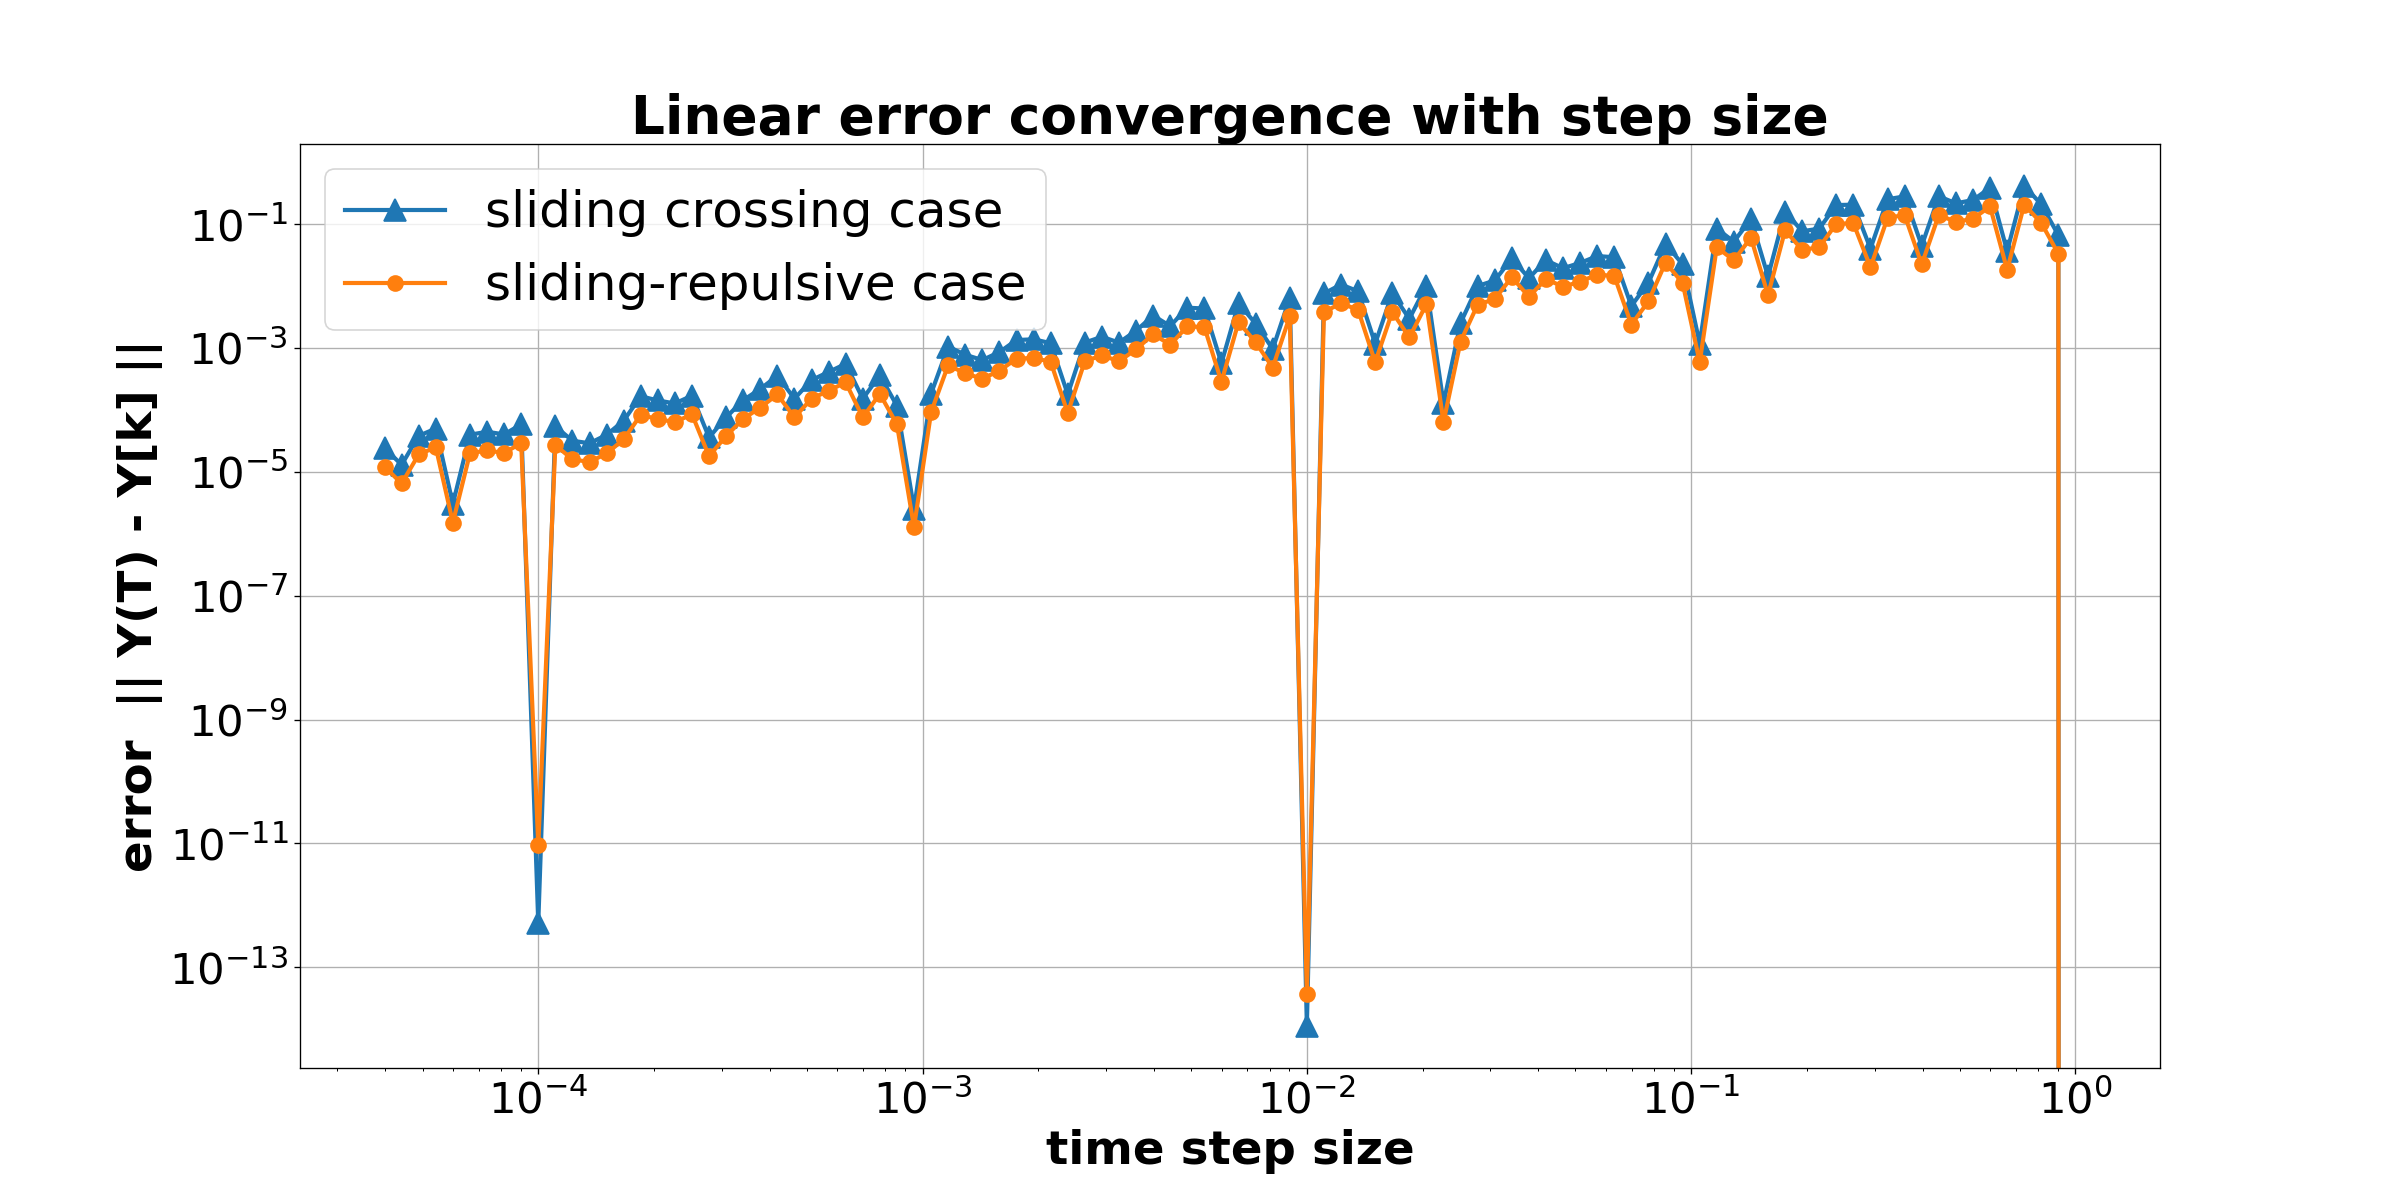

In [10]:
import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

hstep_size = timeSteps
lcp_uniq_err = error_sliding_crossing
lcp_notuniq_err = error_sliding_repulsive
lcp_lin_err = error_non_null_A
plt.figure(figsize=(20,10))
plt.title('Linear error convergence with step size',fontsize=32,fontweight='heavy')
c1 = plt.plot(hstep_size,lcp_uniq_err, linewidth=2.5, marker='^', markersize=13, label='sliding crossing case')
c2 = plt.plot(hstep_size,lcp_notuniq_err, linewidth=2.5, marker='.', markersize=18, label='sliding-repulsive case')
# c3 = plt.plot(hstep_size,lcp_lin_err, linewidth=2.5, marker='x', markersize=15 ,label='non null matrix A')
plt.xlabel('time step size',fontsize=28,fontweight='bold')
plt.ylabel('error  || Y(T) - Y[k] ||',fontsize=28,fontweight='bold')
plt.xscale('log')
plt.yscale('log')
ax = plt.axes()
ax.tick_params(axis='both', labelsize='26')
plt.legend(fancybox=True, fontsize=30)
plt.grid()

<IPython.core.display.Javascript object>


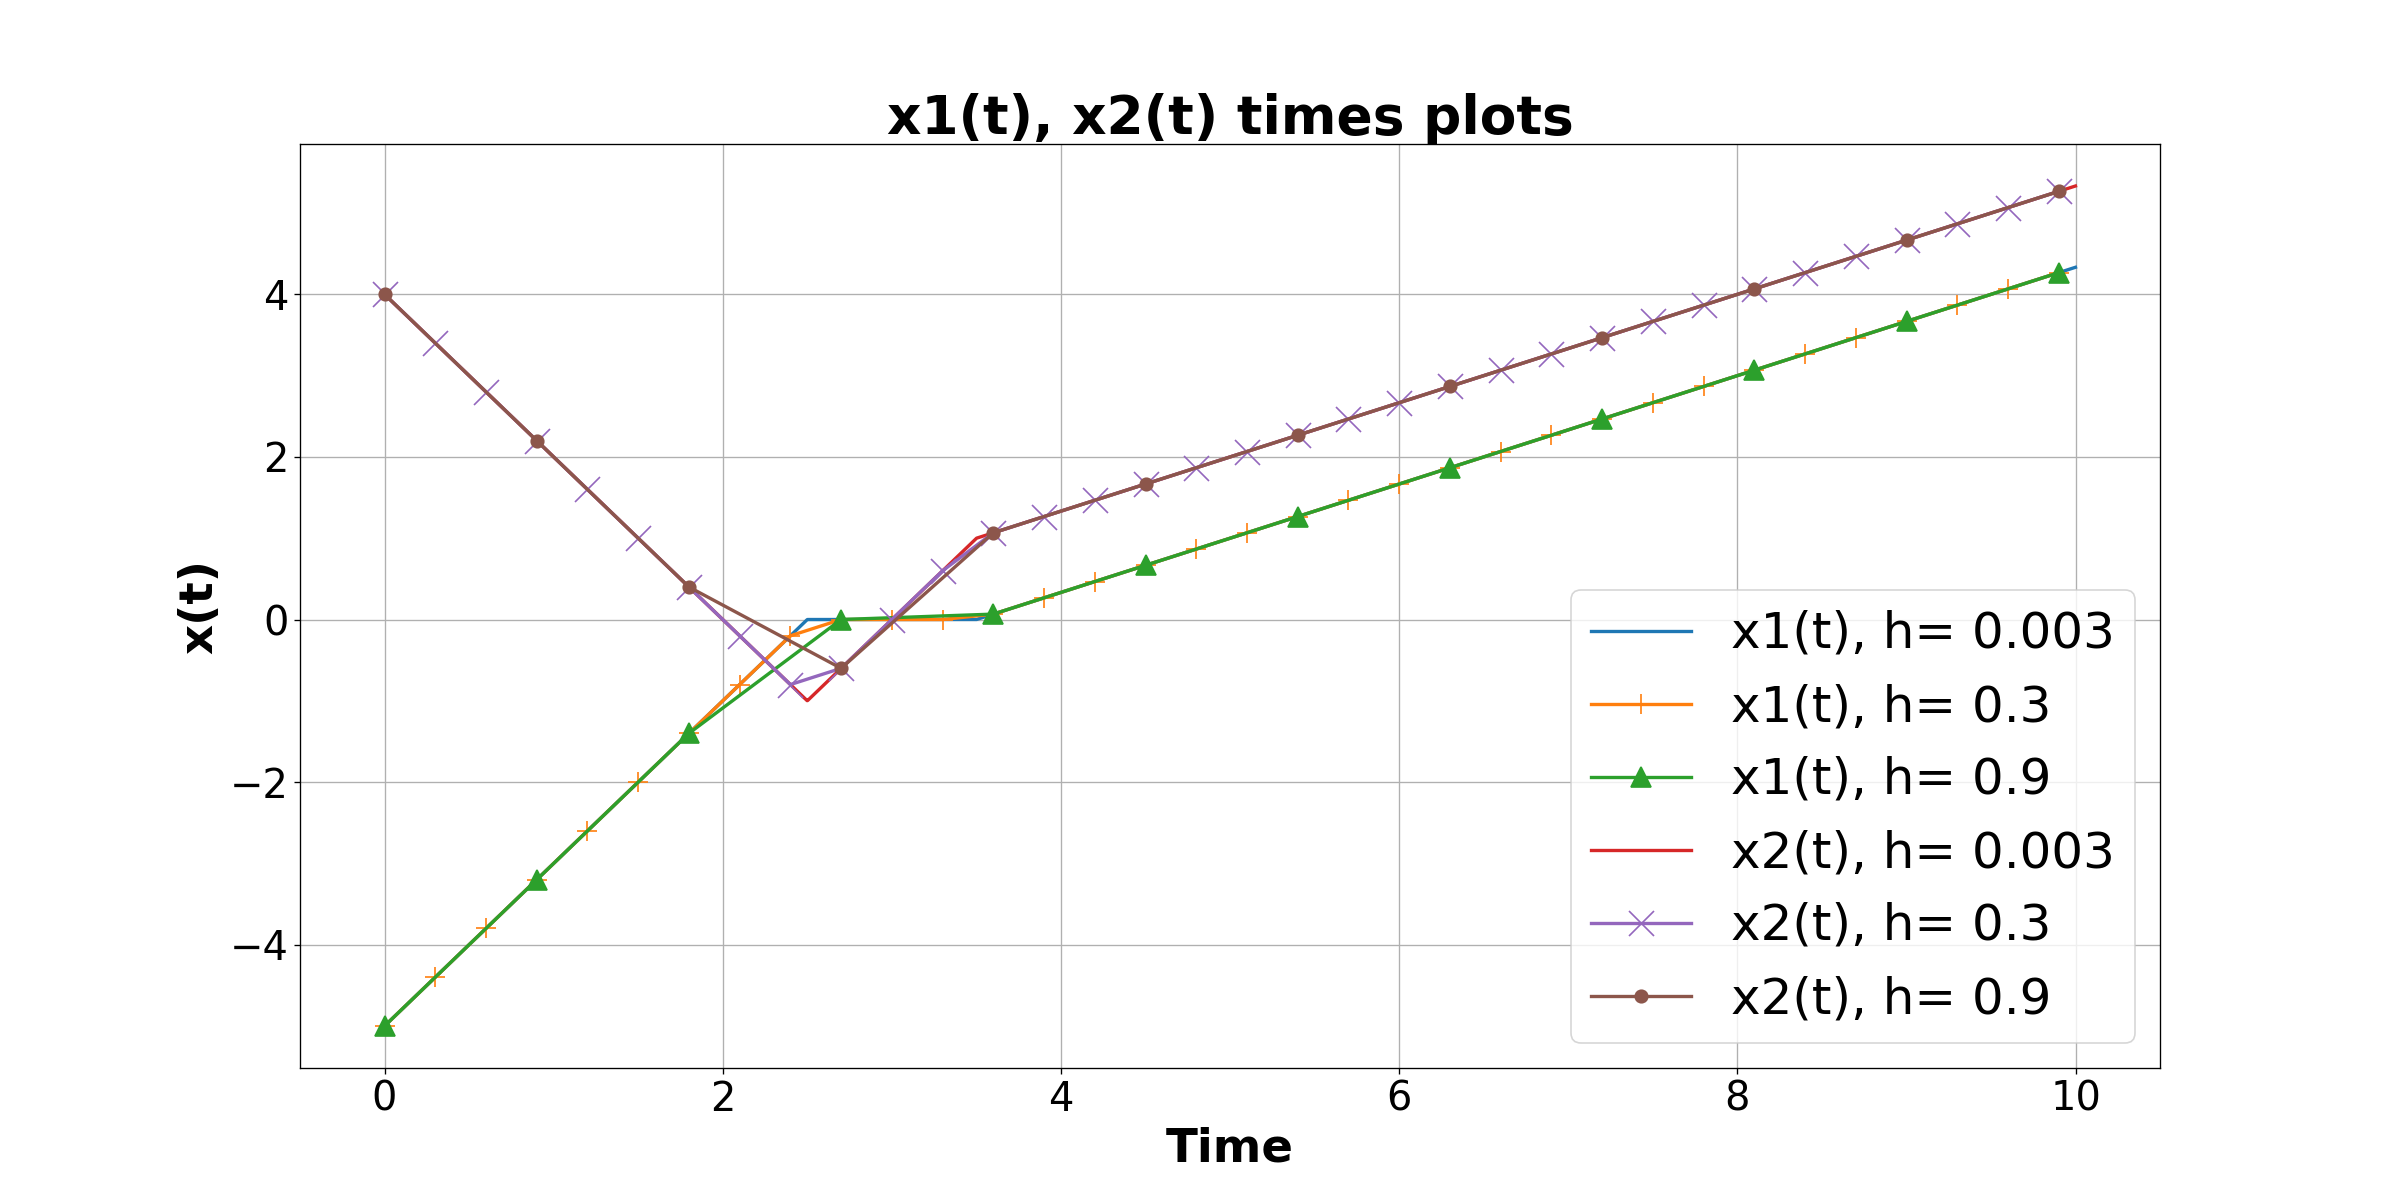

<IPython.core.display.Javascript object>


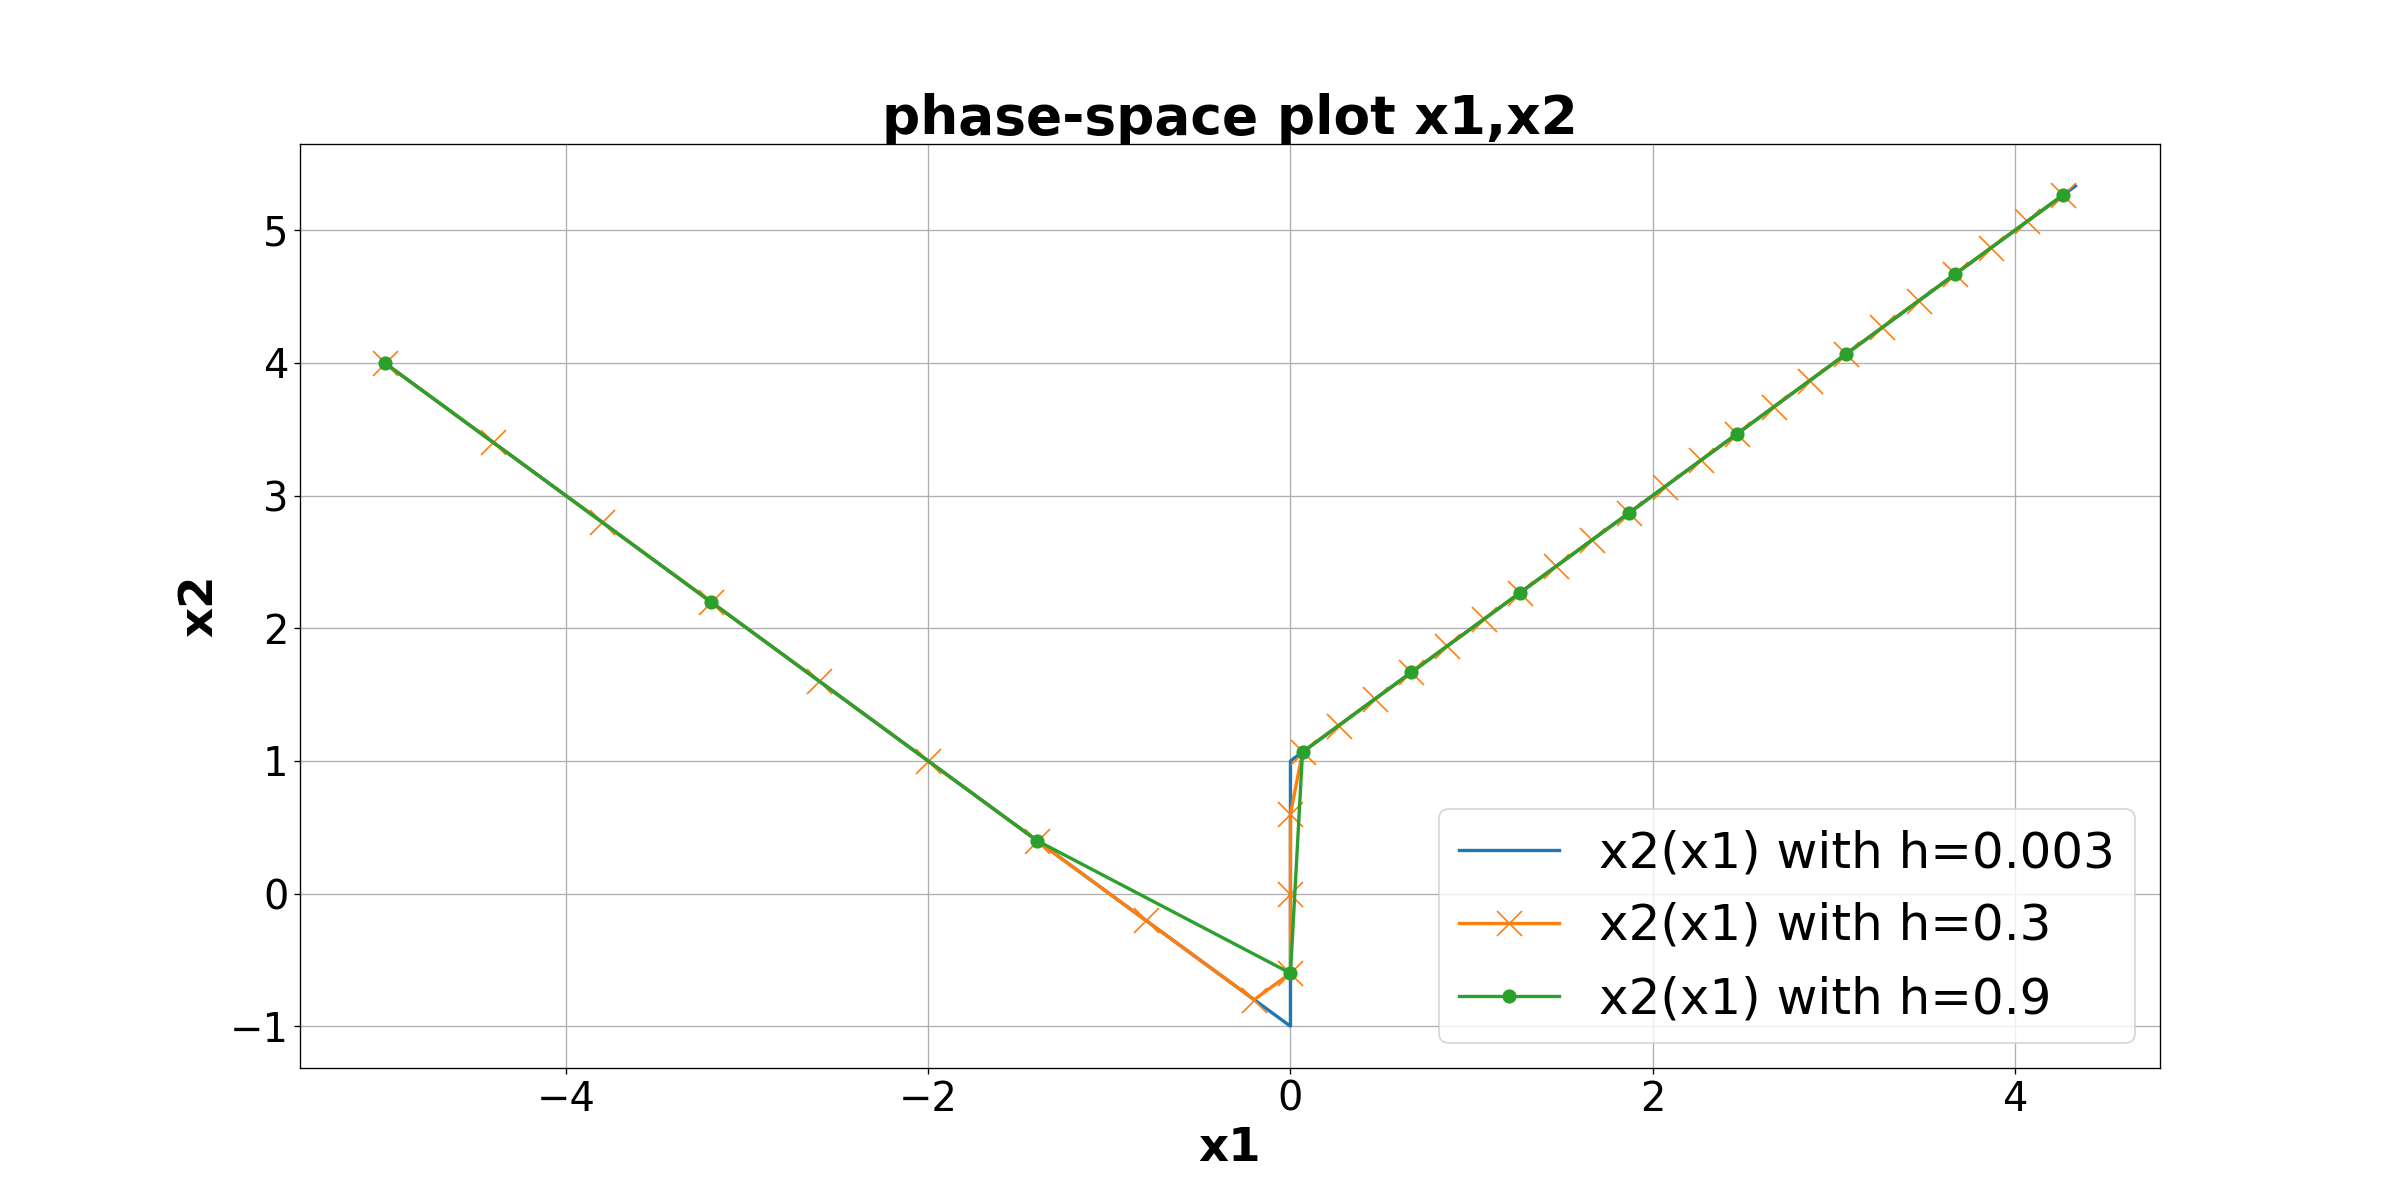

In [17]:
import ipympl
import matplotlib.pyplot as plt
%matplotlib notebook

init  = [-5,4,0]
T = 10

B = [-0.5,1.0] # When considering constant and the linear dynamic of x 

A = zeros((3,3))
A[0,2] = B[0]
A[1,2] = B[1]
A[2,1] = -1
A[2,0] = 1
b =  np.array([1,0,1])

M = np.eye(3)
M[2,2] = 0

R= zeros((3,3));
R[2,0] = 1 
R[2,1] = -1

C = zeros((3,3)); 
C[0,0] = 2; 
C[1,0] = 1;

D = zeros((3,3)); 
D[0,0] = 1;
D[1,2] = 1; 
D[2,1] = -1;

e = [0,0,2] 

typeProblem = 'sliding-crossing'

pb = Problem(A,R,b,C,D,e,M,init,T,typeProblem)
test = ConvergenceTest(pb,timeSteps)
results_0_003 = test.simulate(pb,0.003)
results_0_3 = test.simulate(pb,0.3)
results_0_9 = test.simulate(pb,0.9)

plt.figure(figsize=(20,10))
plt.title('x1(t), x2(t) times plots',fontsize=32,fontweight='heavy')
plt.plot(results_0_003[: , 0], results_0_003[: , 1], linewidth=2.,label='x1(t), h= 0.003')
plt.plot(results_0_3[: , 0], results_0_3[: , 1], linewidth=2., marker='+', markersize=12,label='x1(t), h= 0.3')
plt.plot(results_0_9[: , 0], results_0_9[:, 1], linewidth=2., marker='^', markersize=12,label='x1(t), h= 0.9')
plt.plot(results_0_003[:, 0], results_0_003[:, 2], linewidth=2.,label='x2(t), h= 0.003')
plt.plot(results_0_3[:, 0], results_0_3[:, 2], linewidth=2., marker='x', markersize=15,label='x2(t), h= 0.3')
plt.plot(results_0_9[:, 0], results_0_9[:, 2], linewidth=2., marker='.', markersize=15,label='x2(t), h= 0.9')
plt.xlabel('Time',fontsize=28,fontweight='bold')
plt.ylabel('x(t)',fontsize=28,fontweight='bold')
plt.grid()
ax = plt.axes()
ax.tick_params(axis='both', labelsize='24')
plt.legend(fancybox=True, fontsize=30)

plt.figure(figsize=(20,10))
plt.title('phase-space plot x1,x2',fontsize=32,fontweight='heavy')
plt.plot(results_0_003[:, 1], results_0_003[: , 2], linewidth=2.,label='x2(x1) with h=0.003')
plt.plot(results_0_3[:, 1], results_0_3[: , 2], linewidth=2., marker='x', markersize=15,label='x2(x1) with h=0.3')
plt.plot(results_0_9[:, 1], results_0_9[:, 2], linewidth=2., marker='.', markersize=15,label='x2(x1) with h=0.9')
plt.xlabel('x1',fontsize=28,fontweight='bold')
plt.ylabel('x2',fontsize=28,fontweight='bold')
plt.grid()
ax = plt.axes()
ax.tick_params(axis='both', labelsize='24')
plt.legend(fancybox=True, fontsize=30)